In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import math

In [2]:
pd.options.display.max_rows = 2000

In [3]:
# database_type = input('What data set wanna use: Small(0), Big(1)')
# if(int(database_type)):
#     ratings_type = 'ratings.csv'
# else:
#     ratings_type = 'ratings_small.csv'

movie_database = pd.read_csv('./notebooks/ml-latest-small/movies.csv')
# users_ratings = pd.read_csv('Data/' + ratings_type)
users_ratings = pd.read_csv('./notebooks/ml-latest-small/ratings.csv')
movie_database.head()
# users_ratings.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movie_database =  movie_database.rename(columns={'id':'movieId'})

# Get the total number of users and movies
num_users = len(pd.unique(users_ratings['userId']))
num_movies = len(pd.unique(movie_database['movieId']))

print("Total number of movies: " + str(num_movies))
print("Total number of users: " + str(num_users))
print(users_ratings.shape)

Total number of movies: 9742
Total number of users: 610
(100836, 4)


In [5]:
'''
Alg:
1. Get userId list list_user
2. Get movieId list list_movie
3. For each user:
    a. Get ratings by user
    b. For each index of ratings in users_ratings dataframe:
        i. Get movieid index (column index) in ratings['movieId']
        ii. Append (user, movie, rating) to output list
4. Returns 3-tuple (output_list, list_user, list_movie)
'''
def get_user_item_pairs():
    list_userId = np.array(pd.unique(users_ratings['userId']))
    list_movieId = np.array(pd.unique(movie_database['movieId']))
    movie_index_list = pd.Index(movie_database['movieId'])
    output_list = []
    # index by user
    for user_index in np.arange(0, len(list_userId)):
        # associated user_id with user
        user_id = list_userId[user_index]
        # ratings by user
        ratings = users_ratings[users_ratings['userId'] == user_id]
        # for each row index associated with user
        for index in ratings.index:
            # get movie id for finding movie index
            movie_id = users_ratings['movieId'].iloc[index]
            # get movie index to place in list
            movie_index = movie_index_list.get_loc(movie_id)#movie_database['movieId'].loc[movie_id]
            # get rating
            rating = users_ratings['rating'].iloc[index]
            output_list.append((user_index, movie_index, rating))
    return (np.array(output_list, dtype='i4,i4,i4'), list_userId, list_movieId)

'''
Input:
    S is a collection of 3-tuples (user, movie, rating)
        user is the index of the user in list_userId
        movie is the index of the movie in list_movieId
        rating is the corresponding rating
    Output: mxn feedback matrix
        m is the length of list_userId
        n is the length of list_movieId
        Entry (i, j) is nonzero if list_userId[i] reviewed list_movieId[j]
'''
def build_feedback_matrix(S, list_userId, list_movieId):
    m = list_userId.shape[0]
    n = list_movieId.shape[0]
    F = np.zeros((m, n))
    for (user_index, movie_index, rating) in S:
        F[user_index, movie_index] = rating
    return F

def data_split(S, split=.5):
    S_perm = np.copy(S)
    np.random.shuffle(S_perm)
    l = S_perm.shape[0]
    train_index = int(l * split)
    train = S_perm[:train_index];
    test = S_perm[train_index:]
    return(train, test)

'''
Train/Validation/Test split for data given by S.
Default split is 40/40/20
'''
def train_validation_test_split(S, train_prop=.4, validation_prop=.4, test_prop=.2):
    if (train_prop + validation_prop + test_prop != 1):
        raise Exception
    (pseudo_train, test) = data_split(S, split=(train_prop+validation_prop))
    (train, validation) = data_split(pseudo_train, split=(train_prop / (train_prop + validation_prop)))
    return (train, validation, test)

'''
K-fold cross validation.
'''
def k_foldCV(S, k=10):
    S_perm = np.copy(S)
    np.random.shuffle(S_perm)
    N = S_perm.shape[0]
    size = int(N / k)
    r = N % k
    folds = []
    index = 0
    for i in range(k):
        if r > 0:
            folds.append(S_perm[index:(index+size + 1)])
            r = r - 1
            index = index + size + 1
        else:
            folds.append(S_perm[index:(index+size)])
            index = index + size
    return np.array(folds)

In [6]:
(user_item_rating, list_userId, list_movieId) = get_user_item_pairs()

In [7]:
user_item_rating

array([(  0,    0, 4), (  0,    2, 4), (  0,    5, 4), ...,
       (609, 9462, 5), (609, 9463, 5), (609, 9503, 3)],
      dtype=[('f0', '<i4'), ('f1', '<i4'), ('f2', '<i4')])

In [8]:
(train_data, validation_data, test_data) = train_validation_test_split(user_item_rating)

In [28]:
# # Build an NxM feedback matrix, N= Users, M= Movies
F_train = build_feedback_matrix(train_data, list_userId, list_movieId)
F_validation = build_feedback_matrix(validation_data, list_userId, list_movieId)
F_test = build_feedback_matrix(test_data, list_userId, list_movieId)

In [10]:
# sns.heatmap(F_train)

In [11]:
# sns.heatmap(F_validation)

In [12]:
# sns.heatmap(F_test)

In [13]:
def calc_loss(E):
    return np.linalg.norm(E, ord='fro')**2


In [22]:
'''
Batch gradient descent algorithm.
(Runtime currently not optimized for sparse matrices.)
Our update equations are defined as
U <- U + alpha* EV
V <- V + alpha E'U

where E = F - UV' is the residual matrix
'''
def gradient_descent(F, alpha=0.0005, K=50, d=2):
    m = F.shape[0] # Number of users in feedback matrix
    n = F.shape[1] # Number of items in feedback matrix
    U = np.random.rand(m, d)
    V = np.random.rand(n, d)
    # Sanity check: we keep Frobenius norm at each step to measure our
    # loss wrt the objective function
    cost = []
    # Stop condition is currently not relative to convergence,
    # but a fixed number of iterations
    for i in np.arange(1, K):
        E = F - (U @ V.T) # Residual matrix
        iter_cost = calc_loss(E)
        cost.append(iter_cost)
        print(iter_cost)
        # Intermediate U and V to insure simultaneous step
        U_new = U + (alpha * (E @ V))
        V_new = V + (alpha * (E.T @ U))
        U = U_new
        V = V_new
    
    return (U, V, cost)

'''
Wrapper that takes in feedback matrix data as a
list of 3-tuples (row, col, rating). Written to
help with cross validation
'''
def train(S, list_userId, list_movieId, alpha, K, d):
    F_train = build_feedback_matrix(S, list_userId, list_movieId)
    return (F_train, gradient_descent(F_train, alpha, K, d))

In [15]:
'''
Calculate the MSE of F_hat with respect to F
S is a list of 3-tuples (i, j, rating)
We calculate the MSE over cells (i, j) found in S.
'''
def MSE(S, F, F_hat):
    # size of MSE calculation
    N = S.shape[0]
    mse = 0
    for (row, col, r) in S:
        residual = F_hat[row, col] - F[row, col]
        mse = mse + (residual**2)
    mse = mse / N
    return mse

'''
Calculate the RMSE of F_hat with respect to F
S is a list of 3-tuples (i, j, rating)
We calculate the RMSE over cells (i, j) found in S.
'''
def RMSE(S, F, F_hat):
    return math.sqrt(MSE(S, F, F_hat))

In [16]:
folds = k_foldCV(train_data, k=5)

accuracy_train = []
accuracy_validation = []
for i in range(len(folds)):
    holdout = folds[i]
    selector = [j for j in range(len(folds)) if j != i]
    train_folds = folds[selector]
    train_set = np.concatenate(train_folds)
    (F_train, (U, V, cost)) = train(train_set, list_userId, list_movieId, alpha=0.00005, K=50, d=2)
    F_hat = U @ V.T
    rmse_train = RMSE(train_set, F_train, F_hat)
    rmse_validation = RMSE(holdout, F_train, F_hat)
    accuracy_train.append(rmse_train)
    accuracy_validation.append(rmse_validation)

print(accuracy_train)
print(accuracy_validation)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[3.467191436339604, 3.4709247048851894, 3.4741546825973866, 3.4715655071223464, 3.470121197065895]
[0.08629952513520217, 0.08662844108177416, 0.0872814786714835, 0.08888504999627525, 0.08566773094700128]


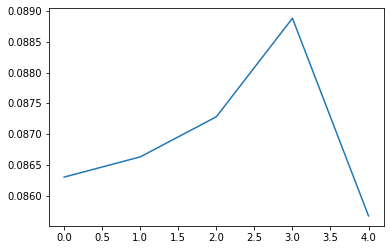

In [17]:
# plt.plot(accuracy_train)
plt.plot(accuracy_validation)

In [29]:
U, V, cost = gradient_descent(F_train, .00005, 5000, 2)

2398421.240738765
1454375.7391517085
1005017.1510608869
776475.9465332746
655956.2192593721
590906.6441700888
555118.9240998877
535016.4442911021
523414.15108905593
516462.3820014053
512082.8349488403
509147.4293594069
507040.835220057
505425.44645194995
504114.50197772385
503003.3900221856
502032.38265651936
501166.3896625396
500383.94210189645
499671.1864562635
499018.6012752632
498419.1944963944
497867.50702946755
497359.0561517564
496890.0194698104
496457.05102762923
496057.1704921847
495687.69317509263
495346.18324184575
495030.4204044389
494738.3747239224
494468.18651518173
494218.14964266215
493986.6972097073
493772.3890404829
493573.90057586116
493390.0129318052
493219.60394316685
493061.6400610438
492915.16900037165
492779.31305352197
492653.2629992346
492536.27254614275
492427.653258098
492326.7699147885
492233.0362664661
492145.91114614817
492064.8949064833
491989.5261519231
491919.3787398005
491854.05902652757
491793.2033374926
491736.47564127
491683.5654106045
491634.18565

488604.6096862434
488597.7447270579
488590.8767593428
488584.00578323606
488577.13179888116
488570.2548064187
488563.3748059931
488556.49179774866
488549.60578183236
488542.7167583895
488535.8247275705
488528.92968952405
488522.03164440155
488515.13059235347
488508.2265335358
488501.3194681012
488494.4093962071
488487.4963180081
488480.58023366414
488473.66114333435
488466.73904717824
488459.81394536037
488452.88583804027
488445.95472538477
488439.02060755837
488432.083484727
488425.1433570589
488418.2002247234
488411.2540878911
488404.3049467316
488397.3528014197
488390.39765212813
488383.43949902966
488376.47834230313
488369.5141821254
488362.5470186729
488355.5768521273
488348.6036826672
488341.6275104777
488334.6483357384
488327.6661586351
488320.68097935384
488313.6927980791
488306.7016150005
488299.70743030513
488292.7102441837
488285.7100568276
488278.7068684286
488271.70067917847
488264.69148927374
488257.6792989105
488250.66410828306
488243.64591759065
488236.62472703145
48822

485198.7678651695
485190.5703063873
485182.36987036944
485174.16655736906
485165.9603676351
485157.75130142027
485149.5393589729
485141.32454053883
485133.1068463673
485124.8862767012
485116.66283178254
485108.43651185575
485100.2073171609
485091.9752479388
485083.7403044251
485075.5024868583
485067.2617954712
485059.01823050366
485050.77179218276
485042.5224807413
485034.2702964098
485026.015239416
485017.75730998564
485009.4965083459
485001.23283472104
484992.9662893316
484984.6968724003
484976.4245841455
484968.1494247866
484959.87139453954
484951.5904936195
484943.3067222402
484935.0200806128
484926.7305689498
484918.4381874577
484910.14293634484
484901.84481581784
484893.54382607987
484885.23996733484
484876.93323978275
484868.62364362215
484860.3111790537
484851.9958462714
484843.67764547054
484835.35657684447
484827.0326405846
484818.70583687816
484810.37616591604
484802.04362788383
484793.7082229655
484785.3699513458
484777.02881320467
484768.6848087193
484760.33793807175
48475

481247.9122895506
481238.41926628636
481228.92321067845
481219.4241214799
481209.92199743603
481200.4168372872
481190.90863976936
481181.39740361425
481171.8831275467
481162.3658102881
481152.8454505533
481143.3220470536
481133.79559849505
481124.2661035774
481114.7335609944
481105.1979694389
481095.6593275958
481086.1176341436
481076.5728877591
481067.02508711227
481057.4742308673
481047.92031768337
481038.3633462161
481028.8033151157
481019.2402230266
481009.67406858644
481000.1048504317
480990.53256719053
480980.95721748914
480971.378799945
480961.7973131701
480952.2127557776
480942.62512636813
480933.034423543
480923.4406458934
480913.8437920102
480904.24386047386
480894.6408498659
480885.0347587572
480875.42558571754
480865.8133293084
480856.1979880904
480846.57956061227
480836.95804542553
480827.3334410707
480817.70574608725
480808.0749590043
480798.4410783531
480788.80410265375
480779.1640304236
480769.5208601754
480759.87459041516
480750.2252196443
480740.572746361
480730.91716

476664.9660731605
476653.92256355647
476642.87506718433
476631.8235817229
476620.7681048647
476609.7086343008
476598.64516772924
476587.57770285284
476576.50623737846
476565.430769018
476554.35129549215
476543.26781452197
476532.1803238358
476521.088821168
476509.9933042562
476498.8937708448
476487.7902186864
476476.682645533
476465.5710491462
476454.4554272941
476443.3357777486
476432.21209828596
476421.0843866922
476409.952640756
476398.816858273
476387.67703704536
476376.5331748812
476365.38526959234
476354.23331900133
476343.07732093486
476331.9172732231
476320.7531737059
476309.5850202299
476298.412810646
476287.2365428137
476276.0562145965
476264.871823866
476253.6833685032
476242.4908463915
476231.2942554237
476220.0935934998
476208.8888585229
476197.6800484073
476186.4671610764
476175.2501944546
476164.0291464765
476152.80401508464
476141.57479822886
476130.3414938668
476119.10409995914
476107.86261447944
476096.6170354105
476085.3673607354
476074.1135884509
476062.8557165579
4

471301.66274185374
471288.78701658145
471275.90780465235
471263.02511320595
471250.1389494212
471237.2493205154
471224.35623374133
471211.4596963889
471198.5597157861
471185.6562992992
471172.7494543289
471159.83918831655
471146.92550874024
471134.0084231151
471121.08793899475
471108.1640639686
471095.2368056671
471082.3061717525
471069.3721699321
471056.4348079455
471043.4940935742
471030.55003463506
471017.6026389819
471004.6519145087
470991.6978691482
470978.74051086797
470965.7798476765
470952.81588761776
470939.8486387776
470926.87810927577
470913.9043072743
470900.9272409699
470887.94691859913
470874.9633484367
470861.9765387948
470848.9864980281
470835.9932345242
470822.99675671116
470809.9970730574
470796.99419206625
470783.98812228185
470770.9788722872
470757.96645070217
470744.95086618786
470731.9321274398
470718.9102431965
470705.8852222325
470692.8570733625
470679.82580543926
470666.7914273524
470653.7539480341
470640.71337645315
470627.66972161556
470614.6229925716
470601.

465313.49949903757
465300.3356088698
465287.1749771388
465274.01762382814
465260.86356892553
465247.71283241967
465234.56543429877
465221.4213945509
465208.280733162
465195.14347012184
465182.0096254153
465168.8792190294
465155.75227094843
465142.6288011549
465129.50882963365
465116.39237636316
465103.2794613233
465090.17010449106
465077.06432584074
465063.9621453453
465050.863582976
465037.7686586987
465024.67739247833
465011.5898042749
464998.5059140489
464985.4257417539
464972.3493073423
464959.2766307589
464946.2077319476
464933.14263084944
464920.0813473955
464907.0239015192
464893.97031314496
464880.9206021908
464867.8747885742
464854.8328922056
464841.79493298655
464828.7609308171
464815.7309055904
464802.70487719204
464789.6828655029
464776.6648903953
464763.6509717382
464750.641129391
464737.6353832064
464724.63375303237
464711.63625870366
464698.64292005525
464685.6537569075
464672.66878907726
464659.6880363708
464646.7115185868
464633.7392555139
464620.77126693685
464607.807

460024.38465392217
460014.3913397646
460004.407819876
459994.43409962417
459984.4701843279
459974.51607925637
459964.57178963313
459954.63732062833
459944.7126773697
459934.7978649299
459924.8928883406
459914.99775257974
459905.11246257817
459895.23702321935
459885.371439337
459875.515715719
459865.6698571025
459855.8338681778
459846.00775358727
459836.1915179244
459826.3851657346
459816.5887015164
459806.80212971836
459797.0254547429
459787.2586809439
459777.5018126267
459767.75485405046
459758.0178094237
459748.2906829101
459738.5734786244
459728.8662006327
459719.1688529549
459709.48143956193
459699.8039643791
459690.1364312818
459680.47884409875
459670.8312066125
459661.1935225576
459651.56579561933
459641.94802943734
459632.34022760455
459622.7423936641
459613.15453111526
459603.5766434089
459594.0087339472
459584.4508060872
459574.9028631365
459565.3649083589
459555.8369449698
459546.3189761371
459536.8110049831
459527.31303458195
459517.8250679626
459508.3471081063
459498.879157

456507.74399026687
456502.09879194293
456496.46190971916
456490.8333348096
456485.2130584138
456479.6010717255
456473.99736592604
456468.40193218767
456462.8147616727
456457.2358455384
456451.6651749272
456446.10274097393
456440.5485348048
456435.0025475369
456429.4647702776
456423.9351941264
456418.413810172
456412.90060949815
456407.3955831765
456401.8987222688
456396.4100178337
456390.92946091574
456385.4570425548
456379.9927537792
456374.5365856144
456369.08852907165
456363.64857515745
456358.2167148707
456352.79293920135
456347.37723913015
456341.9696056317
456336.5700296748
456331.1785022164
456325.79501420935
456320.4195565993
456315.0521203206
456309.69269630674
456304.3412754751
456298.9978487451
456293.6624070245
456288.33494121436
456283.0154422089
456277.70390089747
456272.4003081599
456267.10465487005
456261.81693189807
456256.537130103
456251.2652403414
456246.0012534608
456240.7451603053
456235.49695170886
456230.2566185039
456225.0241515134
456219.79954155616
456214.582

454674.4439660442
454671.60785235785
454668.7760557698
454665.9485685913
454663.1253831463
454660.30649176455
454657.4918867899
454654.6815605675
454651.8755054565
454649.07371382497
454646.2761780493
454643.48289051215
454640.6938436101
454637.9090297434
454635.12844132667
454632.3520707794
454629.57991053245
454626.8119530244
454624.0481907022
454621.288616025
454618.53322145675
454615.78199947556
454613.034942562
454610.292043211
454607.5532939261
454604.81868721684
454602.0882156048
454599.3618716175
454596.6396477959
454593.92153668724
454591.20753084775
454588.4976228419
454585.7918052475
454583.0900706472
454580.39241163305
454577.69882081106
454575.0092907882
454572.32381418865
454569.64238363976
454566.96499178134
454564.2916312614
454561.62229473627
454558.95697487396
454556.2956643481
454553.63835584524
454550.9850420567
454548.33571568667
454545.6903694487
454543.04899606196
454540.41158825764
454537.77813877567
454535.1486403649
454532.5230857831
454529.901467798
454527.28

453736.79260845075
453735.2557734388
453733.72070607974
453732.18740252085
453730.6558589113
453729.12607141124
453727.5980361852
453726.07174940745
453724.54720725596
453723.0244059172
453721.5033415856
453719.9840104611
453718.46640874876
453716.95053266623
453715.4363784304
453713.923942272
453712.4132204243
453710.90420912806
453709.3969046342
453707.891303195
453706.3874010737
453704.88519453764
453703.3846798649
453701.8858533371
453700.3887112413
453698.8932498756
453697.39946554083
453695.9073545476
453694.4169132128
453692.9281378571
453691.44102481153
453689.9555704132
453688.47177100345
453686.9896229334
453685.50912255846
453684.03026624024
453682.5530503521
453681.0774712671
453679.6035253712
453678.13120905205
453676.66051870666
453675.1914507379
453673.7240015559
453672.25816757575
453670.7939452212
453669.33133092086
453667.8703211102
453666.4109122339
453664.95310073905
453663.4968830815
453662.04225572426
453660.58921513445
453659.137757789
453657.6878801686
453656.23

453179.12419127347
453178.0812665825
453177.03894795885
453175.9972337891
453174.95612246654
453173.9156123869
453172.87570194964
453171.83638955356
453170.7976736072
453169.7595525166
453168.72202469636
453167.68508856004
453166.6487425251
453165.6129850151
453164.57781445334
453163.5432292703
453162.50922789343
453161.47580876254
453160.4429703111
453159.4107109822
453158.3790292203
453157.3479234712
453156.31739218876
453155.28743382613
453154.2580468368
453153.22922968655
453152.2009808341
453151.1732987495
453150.14618190227
453149.119628764
453148.0936378127
453147.0682075265
453146.0433363876
453145.0190228827
453143.9952655
453142.9720627328
453141.94941307424
453140.92731502367
453139.90576708206
453138.88476775534
453137.86431554845
453136.84440897306
453135.82504654437
453134.80622677703
453133.7879481925
453132.7702093126
453131.7530086637
453130.7363447753
453129.7202161798
453128.7046214119
453127.68955900933
453126.67502751417
453125.6610254709
453124.6475514265
453123.6

In [24]:
min(cost)

374348.8934601901

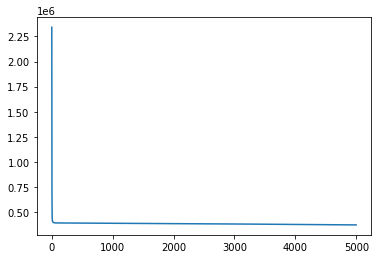

In [25]:
plt.plot(cost)

<AxesSubplot:>

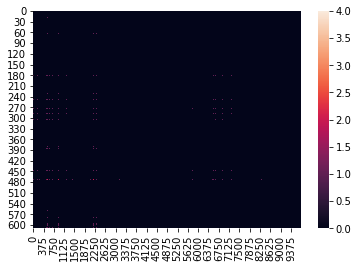

In [26]:
F_approx = U@V.T
sns.heatmap(np.round(F_approx))

In [22]:
def compare(F, F_approx, row, col):
    return_str = 'F_({i},{j}): {f}\tUV\'_({i},{j}): {fhat}\n'.format(i=row,j=col,f=F[row,col],fhat=F_approx[row,col])
    return return_str

In [23]:
for j in np.arange(0, F.shape[0]+1):
    print(compare(F, F_approx, 460, j))

NameError: name 'F' is not defined

In [ ]:
MSE(train, F, np.round(F_approx))

In [ ]:
RMSE(train, F, np.round(F_approx))